In [2]:
import mlflow

# Use only the base URL for API calls
mlflow.set_tracking_uri("http://13.221.75.66:5000/")

with mlflow.start_run():
    mlflow.log_param("param1", 5)
    mlflow.log_metric("metric1", 0.89)


In [3]:
import numpy as np
import pandas as pd

# -------------------------------------------------
# 1. Load the dataset
# -------------------------------------------------
df = pd.read_csv(
    r"https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv"
)

# Preview the first 5 rows
df.head()

# Check dataset dimensions (rows, columns)
df.shape

# Randomly sample one value from 'clean_comment'
df.sample()['clean_comment'].values

# Display dataset information (columns, data types, null counts)
df.info()

# -------------------------------------------------
# 2. Handle missing values
# -------------------------------------------------
# Show rows where 'clean_comment' is NaN
df[df['clean_comment'].isna()]

# Show category counts for NaN 'clean_comment'
df[df['clean_comment'].isna()]['category'].value_counts()

# Drop rows with NaN values in any column
df.dropna(inplace=True)

# -------------------------------------------------
# 3. Remove duplicates
# -------------------------------------------------
# Count duplicate rows
df.duplicated().sum()

# Display duplicate rows (if any)
df[df.duplicated()]

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Confirm duplicates removed
df.duplicated().sum()

# -------------------------------------------------
# 4. Remove empty or whitespace-only strings
# -------------------------------------------------
# Find rows where 'clean_comment' is empty or only spaces
df[(df['clean_comment'].str.strip() == '')]

# Keep only non-empty comments
df = df[~(df['clean_comment'].str.strip() == '')]

# -------------------------------------------------
# 5. Convert all text to lowercase
# -------------------------------------------------
df['clean_comment'] = df['clean_comment'].str.lower()

# -------------------------------------------------
# 6. Detect leading/trailing spaces
# -------------------------------------------------
df[df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' '))]

# -------------------------------------------------
# 7. Remove leading/trailing spaces
# -------------------------------------------------
df['clean_comment'] = df['clean_comment'].str.strip()

# -------------------------------------------------
# 8. Verify no leading/trailing spaces remain
# -------------------------------------------------
df['clean_comment'].apply(lambda x: x.endswith(' ') or x.startswith(' '))

# -------------------------------------------------
# 9. Identify comments containing URLs
# -------------------------------------------------
url_pattern = r'https?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Filter rows containing URLs
comments_with_urls = df[df['clean_comment'].str.contains(url_pattern, regex=True)]

# Display first few comments with URLs
comments_with_urls.head()

# -------------------------------------------------
# 10. Identify comments containing newline characters
# -------------------------------------------------
comments_with_newline = df[df['clean_comment'].str.contains('\n', regex=True)]
comments_with_newline.head()

# -------------------------------------------------
# 11. Remove newline characters by replacing them with a space
# -------------------------------------------------
df['clean_comment'] = df['clean_comment'].str.replace('\n', ' ', regex=True)

# -------------------------------------------------
# 12. Verify that newline characters are removed
# -------------------------------------------------
comments_with_newline_remaining = df[df['clean_comment'].str.contains('\n', regex=True)]
comments_with_newline_remaining






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


,clean_comment,category


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
from wordcloud import WordCloud


# Download NLTK stopwords if not already present
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) - {'not', 'but', 'no', 'yet'}

# -----------------------
# Feature Engineering
# -----------------------

# Word count
df['word_count'] = df['clean_comment'].apply(lambda x: len(x.split()))

# Stopword count
def count_stopwords(text):
    return sum(1 for word in text.split() if word in stop_words)
df['stopword_count'] = df['clean_comment'].apply(count_stopwords)

# Character count
df['num_chars'] = df['clean_comment'].apply(len)

# Punctuation count
def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)
df['num_punctuation_marks'] = df['clean_comment'].apply(count_punctuation)

# Remove stopwords for clean text
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])
df['clean_comment_nostop'] = df['clean_comment'].apply(remove_stopwords)

# -----------------------
# Visualization (MLflow Logging)
# -----------------------

with mlflow.start_run():
    # 1. Category distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x="category")
    plt.title("Sentiment Category Distribution")
    mlflow.log_figure(plt.gcf(), "category_distribution.png")
    plt.close()

    # 2. Word count distribution
    sns.displot(df['word_count'], kde=True)
    plt.title("Word Count Distribution")
    mlflow.log_figure(plt.gcf(), "word_count_distribution.png")
    plt.close()

    # 3. Boxplot of word count by category
    plt.figure(figsize=(8,6))
    sns.boxplot(x='category', y='word_count', data=df, order=[0,1,-1])
    plt.xticks([0,1,2], ['Neutral', 'Positive', 'Negative'])
    plt.title("Word Count by Sentiment")
    mlflow.log_figure(plt.gcf(), "word_count_boxplot.png")
    plt.close()

    # 4. Top 20 stopwords
    all_stopwords = [word for comment in df['clean_comment'] for word in comment.split() if word in stop_words]
    stopword_df = pd.DataFrame(Counter(all_stopwords).most_common(20), columns=['stopword', 'frequency'])
    plt.figure(figsize=(10,6))
    sns.barplot(x='stopword', y='frequency', data=stopword_df, palette='viridis')
    plt.xticks(rotation=45)
    plt.title("Top 20 Stopwords")
    mlflow.log_figure(plt.gcf(), "top_stopwords.png")
    plt.close()

    # 5. Word cloud
    text = ' '.join(df['clean_comment'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Comments")
    mlflow.log_figure(plt.gcf(), "wordcloud.png")
    plt.close()

    # 6. Top 25 bigrams
    def get_bigrams(text):
        words = text.split()
        return list(zip(words, words[1:]))
    bigram_df = pd.DataFrame(Counter([bigram for comment in df['clean_comment'] for bigram in get_bigrams(comment)]).most_common(25), columns=['bigram', 'frequency'])
    bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))
    plt.figure(figsize=(10, 6))
    sns.barplot(x='frequency', y='bigram', data=bigram_df, palette='magma')
    plt.title("Top 25 Bigrams")
    mlflow.log_figure(plt.gcf(), "top_bigrams.png")
    plt.close()

    # Log basic metrics
    mlflow.log_metric("avg_word_count", df['word_count'].mean())
    mlflow.log_metric("avg_stopword_count", df['stopword_count'].mean())
    mlflow.log_metric("avg_num_chars", df['num_chars'].mean())
    mlflow.log_metric("avg_punctuation_count", df['num_punctuation_marks'].mean())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deepu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Deepu\AppData\Local\Temp\ipykernel_26124\3602070586.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stopword', y='frequency', data=stopword_df, palette='viridis')
C:\Users\Deepu\AppData\Local\Temp\ipykernel_26124\3602070586.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='bigram', data=bigram_df, palette='magma')


In [5]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_comment'])
y = df['category']

In [7]:
X

<36793x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 710243 stored elements in Compressed Sparse Row format>

In [8]:
X.shape

(36793, 5000)

In [11]:
mlflow.set_tracking_uri("http://13.221.75.66:5000/")

In [12]:
mlflow.set_experiment("BaselineModel")

2025/08/14 12:41:58 INFO mlflow.tracking.fluent: Experiment with name 'BaselineModel' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://capstone-mlflow/771611687038846170', creation_time=1755155520051, experiment_id='771611687038846170', last_update_time=1755155520051, lifecycle_stage='active', name='BaselineModel', tags={}>

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Train RandomForestClassifier and log with MLflow
with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.set_tag(
        "description",
        "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split"
    )

    # Log vectorizer parameters
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Model hyperparameters
    n_estimators = 100
    max_depth = 10
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Train the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Log accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    # Classification report (all metrics)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    # Log every metric from classification_report
    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", metric_value)

    # Save and log report as artifact
    classification_df = pd.DataFrame(classification_rep).transpose()
    classification_df.to_csv("classification_report.csv")

    df.to_csv("df.csv", index=False)  # Assuming df exists earlier in your code

    mlflow.log_artifact("classification_report.csv")
    mlflow.log_artifact("df.csv")

    # Log the trained model
    mlflow.sklearn.log_model(model, "model")

print("Run complete. Accuracy:", accuracy)


c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run complete. Accuracy: 0.6170675363500475


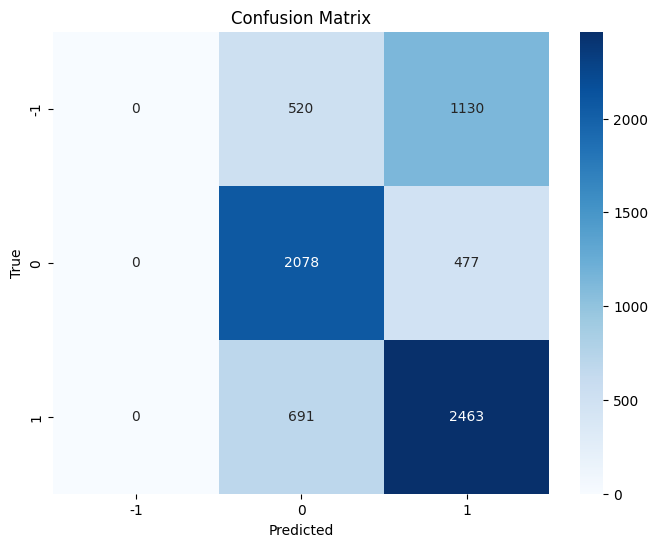

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


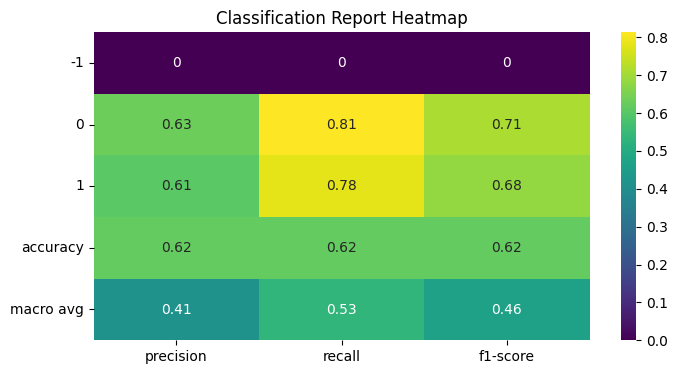

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1650
           0       0.63      0.81      0.71      2555
           1       0.61      0.78      0.68      3154

    accuracy                           0.62      7359
   macro avg       0.41      0.53      0.46      7359
weighted avg       0.48      0.62      0.54      7359



c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Deepu\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# Classification report (numeric table + heatmap)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()

plt.figure(figsize=(8, 4))
sns.heatmap(classification_df.iloc[:-1, :-1], annot=True, cmap="viridis")
plt.title("Classification Report Heatmap")
plt.show()

# Also print the classification report text
print(classification_report(y_test, y_pred))


In [16]:
df.to_csv('reddit_preprocessing.csv',index = False)

In [17]:
pd.read_csv('reddit_preprocessing.csv')

,clean_comment,category,word_count,stopword_count,num_chars,num_punctuation_marks,clean_comment_nostop
0,family mormon have never tried explain them th...,1,39,13,259,0,family mormon never tried explain still stare ...
1,buddhism has very much lot compatible with chr...,1,196,56,1268,0,buddhism much lot compatible christianity espe...
2,seriously don say thing first all they won get...,-1,86,40,459,0,seriously say thing first get complex explain ...
3,what you have learned yours and only yours wha...,0,29,14,167,0,learned want teach different focus goal not wr...
4,for your own benefit you may want read living ...,1,112,44,690,0,benefit may want read living buddha living chr...
...,...,...,...,...,...,...,...
36788,jesus,0,1,0,5,0,jesus
36789,kya bhai pure saal chutiya banaya modi aur jab...,1,19,0,99,0,kya bhai pure saal chutiya banaya modi aur jab...
36790,downvote karna tha par upvote hogaya,0,6,0,36,0,downvote karna tha par upvote hogaya
36791,haha nice,1,2,0,9,0,haha nice
